In [ ]:
! unzip -qq data.zip

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/car_numbers/contest02_data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/car_numbers/")

In [2]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [3]:
torch.__version__, torch.cuda.is_available()

('1.8.1+cu101', True)

In [4]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [5]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/car_numbers/data/'
TRAIN_SIZE = 0.8
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
device

device(type='cuda')

In [7]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

In [8]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='/content/drive/MyDrive/Colab Notebooks/car_numbers/data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='/content/drive/MyDrive/Colab Notebooks/car_numbers/data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = []

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 20/10253 [02:16<1:41:14,  1.68it/s]

Loss: 0.8301394


  0%|          | 40/10253 [02:26<1:23:57,  2.03it/s]

Loss: 0.4260078


  1%|          | 60/10253 [02:39<2:01:12,  1.40it/s]

Loss: 0.3458092


  1%|          | 80/10253 [02:49<1:20:17,  2.11it/s]

Loss: 0.3358231


  1%|          | 100/10253 [02:59<1:37:37,  1.73it/s]

Loss: 0.3035451


  1%|          | 120/10253 [03:07<1:12:10,  2.34it/s]

Loss: 0.2823437


  1%|▏         | 140/10253 [03:16<59:58,  2.81it/s]  

Loss: 0.2780928


  2%|▏         | 160/10253 [03:24<1:24:07,  2.00it/s]

Loss: 0.2643150


  2%|▏         | 180/10253 [03:34<1:22:33,  2.03it/s]

Loss: 0.2957299


  2%|▏         | 200/10253 [03:43<1:00:25,  2.77it/s]

Loss: 0.2635214


  2%|▏         | 220/10253 [03:51<1:10:31,  2.37it/s]

Loss: 0.2151628


  2%|▏         | 240/10253 [04:02<2:19:42,  1.19it/s]

Loss: 0.2169472


  3%|▎         | 260/10253 [04:11<1:05:45,  2.53it/s]

Loss: 0.2165755


  3%|▎         | 280/10253 [04:20<1:02:37,  2.65it/s]

Loss: 0.2253147


  3%|▎         | 300/10253 [04:30<1:21:20,  2.04it/s]

Loss: 0.1930985


  3%|▎         | 320/10253 [04:37<1:21:42,  2.03it/s]

Loss: 0.1960180


  3%|▎         | 340/10253 [04:48<1:20:45,  2.05it/s]

Loss: 0.2306227


  4%|▎         | 360/10253 [04:57<1:02:02,  2.66it/s]

Loss: 0.2237800


  4%|▎         | 380/10253 [05:07<1:27:50,  1.87it/s]

Loss: 0.2143477


  4%|▍         | 400/10253 [05:15<56:42,  2.90it/s]

Loss: 0.2111397


  4%|▍         | 420/10253 [05:24<1:13:49,  2.22it/s]

Loss: 0.2236030


  4%|▍         | 440/10253 [05:31<1:06:46,  2.45it/s]

Loss: 0.2205550


  4%|▍         | 460/10253 [05:41<1:10:37,  2.31it/s]

Loss: 0.2086037


  5%|▍         | 480/10253 [05:51<1:11:16,  2.29it/s]

Loss: 0.2646342


  5%|▍         | 500/10253 [05:59<57:06,  2.85it/s]  

Loss: 0.2175343


  5%|▌         | 520/10253 [06:08<1:00:41,  2.67it/s]

Loss: 0.2315160


  5%|▌         | 540/10253 [06:16<1:06:54,  2.42it/s]

Loss: 0.2336167


  5%|▌         | 560/10253 [06:25<59:18,  2.72it/s]  

Loss: 0.2217991


  6%|▌         | 580/10253 [06:34<1:12:57,  2.21it/s]

Loss: 0.2425562


  6%|▌         | 600/10253 [06:44<1:15:09,  2.14it/s]

Loss: 0.2436687


  6%|▌         | 620/10253 [06:51<51:41,  3.11it/s]

Loss: 0.2415349


  6%|▌         | 640/10253 [07:00<1:13:53,  2.17it/s]

Loss: 0.2336178


  6%|▋         | 660/10253 [07:10<1:19:53,  2.00it/s]

Loss: 0.2135607


  7%|▋         | 680/10253 [07:19<53:19,  2.99it/s]

Loss: 0.2103142


  7%|▋         | 700/10253 [07:27<1:05:20,  2.44it/s]

Loss: 0.2216334


  7%|▋         | 720/10253 [07:35<1:07:33,  2.35it/s]

Loss: 0.1819031


  7%|▋         | 740/10253 [07:45<1:03:00,  2.52it/s]

Loss: 0.2216604


  7%|▋         | 760/10253 [07:55<1:22:42,  1.91it/s]

Loss: 0.2343309


  8%|▊         | 780/10253 [08:03<55:55,  2.82it/s]

Loss: 0.2213124


  8%|▊         | 800/10253 [08:15<2:01:41,  1.29it/s]

Loss: 0.2386405


  8%|▊         | 820/10253 [08:23<1:02:50,  2.50it/s]

Loss: 0.2321582


  8%|▊         | 840/10253 [08:33<1:03:11,  2.48it/s]

Loss: 0.2221238


  8%|▊         | 860/10253 [08:41<1:05:26,  2.39it/s]

Loss: 0.2106454


  9%|▊         | 880/10253 [08:51<1:29:45,  1.74it/s]

Loss: 0.2234832


  9%|▉         | 900/10253 [08:59<1:26:47,  1.80it/s]

Loss: 0.1678091


  9%|▉         | 920/10253 [09:09<56:01,  2.78it/s]  

Loss: 0.2042045


  9%|▉         | 940/10253 [09:17<1:36:32,  1.61it/s]

Loss: 0.2139793


  9%|▉         | 960/10253 [09:26<1:14:33,  2.08it/s]

Loss: 0.2067389


 10%|▉         | 980/10253 [09:35<51:19,  3.01it/s]

Loss: 0.1915763


 10%|▉         | 1000/10253 [09:45<1:17:58,  1.98it/s]

Loss: 0.1807880


 10%|▉         | 1020/10253 [09:54<59:53,  2.57it/s]  

Loss: 0.1912567


 10%|█         | 1040/10253 [10:06<1:30:50,  1.69it/s]

Loss: 0.1971658


 10%|█         | 1060/10253 [10:13<1:03:59,  2.39it/s]

Loss: 0.1860192


 11%|█         | 1080/10253 [10:22<1:21:02,  1.89it/s]

Loss: 0.2017166


 11%|█         | 1100/10253 [10:30<55:44,  2.74it/s]

Loss: 0.1852812


 11%|█         | 1120/10253 [10:40<1:15:53,  2.01it/s]

Loss: 0.1873785


 11%|█         | 1140/10253 [10:51<1:02:05,  2.45it/s]

Loss: 0.1737497


 11%|█▏        | 1160/10253 [11:00<1:28:31,  1.71it/s]

Loss: 0.1808207


 12%|█▏        | 1180/10253 [11:10<1:28:21,  1.71it/s]

Loss: 0.1957333


 12%|█▏        | 1200/10253 [11:19<1:07:41,  2.23it/s]

Loss: 0.2011162


 12%|█▏        | 1220/10253 [11:28<1:55:40,  1.30it/s]

Loss: 0.2070067


 12%|█▏        | 1240/10253 [11:36<59:33,  2.52it/s]  

Loss: 0.2139416


 12%|█▏        | 1260/10253 [11:44<58:36,  2.56it/s]

Loss: 0.1996460


 12%|█▏        | 1280/10253 [11:55<1:05:13,  2.29it/s]

Loss: 0.1809434


 13%|█▎        | 1300/10253 [12:03<57:50,  2.58it/s]  

Loss: 0.1721461


 13%|█▎        | 1320/10253 [12:13<1:09:09,  2.15it/s]

Loss: 0.1826233
Epoch    66: reducing learning rate of group 0 to 1.5000e-04.


 13%|█▎        | 1340/10253 [12:23<56:56,  2.61it/s]

Loss: 0.1740834


 13%|█▎        | 1360/10253 [12:33<1:05:46,  2.25it/s]

Loss: 0.2001678


 13%|█▎        | 1380/10253 [12:40<49:48,  2.97it/s]

Loss: 0.1740741


 14%|█▎        | 1400/10253 [12:50<50:12,  2.94it/s]

Loss: 0.1737858


 14%|█▍        | 1420/10253 [12:58<1:18:51,  1.87it/s]

Loss: 0.1947871


 14%|█▍        | 1440/10253 [13:08<1:16:36,  1.92it/s]

Loss: 0.1885944


 14%|█▍        | 1460/10253 [13:16<57:51,  2.53it/s]  

Loss: 0.2010237


 14%|█▍        | 1480/10253 [13:26<57:08,  2.56it/s]  

Loss: 0.1885685


 15%|█▍        | 1500/10253 [13:35<1:25:17,  1.71it/s]

Loss: 0.1852033


 15%|█▍        | 1520/10253 [13:42<1:09:12,  2.10it/s]

Loss: 0.1564967


 15%|█▌        | 1540/10253 [13:52<1:10:47,  2.05it/s]

Loss: 0.1888009


 15%|█▌        | 1560/10253 [14:02<1:02:20,  2.32it/s]

Loss: 0.2102020


 15%|█▌        | 1580/10253 [14:13<1:41:44,  1.42it/s]

Loss: 0.1754152


 16%|█▌        | 1600/10253 [14:21<1:08:46,  2.10it/s]

Loss: 0.1820552


 16%|█▌        | 1620/10253 [14:29<47:32,  3.03it/s]

Loss: 0.1619345


 16%|█▌        | 1640/10253 [14:37<53:43,  2.67it/s]

Loss: 0.1888526


 16%|█▌        | 1660/10253 [14:47<59:56,  2.39it/s]  

Loss: 0.1836542


 16%|█▋        | 1680/10253 [14:56<54:27,  2.62it/s]  

Loss: 0.1744167


 17%|█▋        | 1700/10253 [15:05<1:04:11,  2.22it/s]

Loss: 0.2346478


 17%|█▋        | 1720/10253 [15:16<1:03:47,  2.23it/s]

Loss: 0.1875562


 17%|█▋        | 1740/10253 [15:25<1:10:56,  2.00it/s]

Loss: 0.1994702


 17%|█▋        | 1760/10253 [15:35<1:15:58,  1.86it/s]

Loss: 0.2283621


 17%|█▋        | 1780/10253 [15:43<1:05:55,  2.14it/s]

Loss: 0.1988578


 18%|█▊        | 1800/10253 [15:52<53:11,  2.65it/s]

Loss: 0.1524215


 18%|█▊        | 1820/10253 [16:03<1:51:08,  1.26it/s]

Loss: 0.1754056


 18%|█▊        | 1840/10253 [16:11<58:02,  2.42it/s]  

Loss: 0.1692031


 18%|█▊        | 1860/10253 [16:22<1:32:32,  1.51it/s]

Loss: 0.1916534


 18%|█▊        | 1880/10253 [16:32<58:52,  2.37it/s]  

Loss: 0.1803104


 19%|█▊        | 1900/10253 [16:41<52:06,  2.67it/s]

Loss: 0.1627599


 19%|█▊        | 1920/10253 [16:50<1:13:37,  1.89it/s]

Loss: 0.2237819


 19%|█▉        | 1940/10253 [16:58<57:38,  2.40it/s]  

Loss: 0.1805146


 19%|█▉        | 1960/10253 [17:06<1:05:01,  2.13it/s]

Loss: 0.1993226


 19%|█▉        | 1980/10253 [17:19<1:21:14,  1.70it/s]

Loss: 0.1822386


 20%|█▉        | 2000/10253 [17:28<52:16,  2.63it/s]

Loss: 0.1676746


 20%|█▉        | 2020/10253 [17:37<56:38,  2.42it/s]

Loss: 0.1733246


 20%|█▉        | 2040/10253 [17:46<1:01:37,  2.22it/s]

Loss: 0.1523240


 20%|██        | 2060/10253 [17:56<55:31,  2.46it/s]  

Loss: 0.1592300


 20%|██        | 2080/10253 [18:04<55:35,  2.45it/s]

Loss: 0.1997368


 20%|██        | 2100/10253 [18:14<49:38,  2.74it/s]

Loss: 0.1942493


 21%|██        | 2120/10253 [18:23<56:09,  2.41it/s]

Loss: 0.1872727


 21%|██        | 2140/10253 [18:33<45:57,  2.94it/s]

Loss: 0.2021691


 21%|██        | 2160/10253 [18:41<59:41,  2.26it/s]  

Loss: 0.1639462


 21%|██▏       | 2180/10253 [18:52<1:05:28,  2.06it/s]

Loss: 0.1862708


 21%|██▏       | 2200/10253 [19:00<58:37,  2.29it/s]

Loss: 0.2008513


 22%|██▏       | 2220/10253 [19:08<53:38,  2.50it/s]  

Loss: 0.1727842


 22%|██▏       | 2240/10253 [19:18<1:00:46,  2.20it/s]

Loss: 0.1716642


 22%|██▏       | 2260/10253 [19:27<58:00,  2.30it/s]  

Loss: 0.1931601


 22%|██▏       | 2280/10253 [19:36<54:25,  2.44it/s]

Loss: 0.2060700


 22%|██▏       | 2300/10253 [19:45<58:05,  2.28it/s]  

Loss: 0.1874700


 23%|██▎       | 2320/10253 [19:55<1:04:57,  2.04it/s]

Loss: 0.1752722


 23%|██▎       | 2340/10253 [20:03<49:22,  2.67it/s]

Loss: 0.2005219


 23%|██▎       | 2360/10253 [20:14<55:11,  2.38it/s]  

Loss: 0.1835808


 23%|██▎       | 2380/10253 [20:25<1:00:15,  2.18it/s]

Loss: 0.1757994


 23%|██▎       | 2400/10253 [20:34<51:10,  2.56it/s]

Loss: 0.1718069


 24%|██▎       | 2420/10253 [20:44<54:07,  2.41it/s]

Loss: 0.1949650


 24%|██▍       | 2440/10253 [20:55<1:02:35,  2.08it/s]

Loss: 0.1701797


 24%|██▍       | 2460/10253 [21:05<1:04:09,  2.02it/s]

Loss: 0.1483500


 24%|██▍       | 2480/10253 [21:14<1:24:40,  1.53it/s]

Loss: 0.1756876


 24%|██▍       | 2500/10253 [21:24<1:08:52,  1.88it/s]

Loss: 0.1490033


 25%|██▍       | 2520/10253 [21:36<1:04:25,  2.00it/s]

Loss: 0.1591657


 25%|██▍       | 2540/10253 [21:43<50:03,  2.57it/s]

Loss: 0.1888937


 25%|██▍       | 2560/10253 [21:53<1:06:07,  1.94it/s]

Loss: 0.1811505


 25%|██▌       | 2580/10253 [22:05<1:01:14,  2.09it/s]

Loss: 0.1838512


 25%|██▌       | 2600/10253 [22:14<1:08:22,  1.87it/s]

Loss: 0.2071166


 26%|██▌       | 2620/10253 [22:22<47:48,  2.66it/s]

Loss: 0.1781194


 26%|██▌       | 2640/10253 [22:31<1:02:43,  2.02it/s]

Loss: 0.1763659


 26%|██▌       | 2660/10253 [22:41<1:09:04,  1.83it/s]

Loss: 0.1737731


 26%|██▌       | 2680/10253 [22:50<50:43,  2.49it/s]

Loss: 0.1775130


 26%|██▋       | 2700/10253 [22:59<57:58,  2.17it/s]  

Loss: 0.1879110


 27%|██▋       | 2720/10253 [23:09<52:14,  2.40it/s]

Loss: 0.1944517


 27%|██▋       | 2740/10253 [23:21<48:19,  2.59it/s]

Loss: 0.2075644


 27%|██▋       | 2760/10253 [23:32<59:06,  2.11it/s]  

Loss: 0.1846092


 27%|██▋       | 2780/10253 [23:41<1:01:35,  2.02it/s]

Loss: 0.1856441


 27%|██▋       | 2800/10253 [23:50<41:25,  3.00it/s]

Loss: 0.1646646


 28%|██▊       | 2820/10253 [23:59<49:59,  2.48it/s]

Loss: 0.1752290


 28%|██▊       | 2840/10253 [24:09<1:00:54,  2.03it/s]

Loss: 0.1758338


 28%|██▊       | 2860/10253 [24:19<59:56,  2.06it/s]  

Loss: 0.1946605


 28%|██▊       | 2880/10253 [24:30<1:07:05,  1.83it/s]

Loss: 0.1781926
Epoch   144: reducing learning rate of group 0 to 7.5000e-05.


 28%|██▊       | 2900/10253 [24:39<48:41,  2.52it/s]

Loss: 0.1947374


 28%|██▊       | 2920/10253 [24:49<53:11,  2.30it/s]

Loss: 0.1813768


 29%|██▊       | 2940/10253 [24:58<49:36,  2.46it/s]

Loss: 0.1930349


 29%|██▉       | 2960/10253 [25:09<1:01:00,  1.99it/s]

Loss: 0.1722984


 29%|██▉       | 2980/10253 [25:16<39:42,  3.05it/s]

Loss: 0.1592801


 29%|██▉       | 3000/10253 [25:27<1:18:57,  1.53it/s]

Loss: 0.1606348


 29%|██▉       | 3020/10253 [25:36<51:04,  2.36it/s]

Loss: 0.1966699


 30%|██▉       | 3040/10253 [25:48<1:15:15,  1.60it/s]

Loss: 0.1822121


 30%|██▉       | 3060/10253 [25:58<59:49,  2.00it/s]  

Loss: 0.1768195


 30%|███       | 3080/10253 [26:07<57:30,  2.08it/s]  

Loss: 0.1688200


 30%|███       | 3100/10253 [26:19<1:11:04,  1.68it/s]

Loss: 0.1602222


 30%|███       | 3120/10253 [26:28<47:59,  2.48it/s]

Loss: 0.1823191


 31%|███       | 3140/10253 [26:38<1:00:34,  1.96it/s]

Loss: 0.1441904


 31%|███       | 3160/10253 [26:49<56:38,  2.09it/s]  

Loss: 0.1851400


 31%|███       | 3180/10253 [26:58<42:34,  2.77it/s]

Loss: 0.1845333


 31%|███       | 3200/10253 [27:09<1:00:06,  1.96it/s]

Loss: 0.1524522


 31%|███▏      | 3220/10253 [27:19<1:33:28,  1.25it/s]

Loss: 0.1473598


 32%|███▏      | 3240/10253 [27:29<1:01:47,  1.89it/s]

Loss: 0.1601223


 32%|███▏      | 3260/10253 [27:40<1:36:25,  1.21it/s]

Loss: 0.1581471


 32%|███▏      | 3280/10253 [27:48<1:07:12,  1.73it/s]

Loss: 0.1664464


 32%|███▏      | 3300/10253 [27:57<1:10:31,  1.64it/s]

Loss: 0.1759281


 32%|███▏      | 3320/10253 [28:08<1:08:08,  1.70it/s]

Loss: 0.1883843


 33%|███▎      | 3340/10253 [28:16<52:42,  2.19it/s]

Loss: 0.1840889


 33%|███▎      | 3360/10253 [28:26<47:47,  2.40it/s]

Loss: 0.1643777


 33%|███▎      | 3380/10253 [28:36<1:24:07,  1.36it/s]

Loss: 0.1703594


 33%|███▎      | 3400/10253 [28:46<56:36,  2.02it/s]

Loss: 0.1572553


 33%|███▎      | 3420/10253 [28:56<1:36:48,  1.18it/s]

Loss: 0.1506834


 34%|███▎      | 3440/10253 [29:05<42:53,  2.65it/s]

Loss: 0.1828487


 34%|███▎      | 3460/10253 [29:15<41:08,  2.75it/s]

Loss: 0.1876072


 34%|███▍      | 3480/10253 [29:25<53:45,  2.10it/s]  

Loss: 0.1900622


 34%|███▍      | 3500/10253 [29:33<45:15,  2.49it/s]

Loss: 0.1763022


 34%|███▍      | 3520/10253 [29:41<50:29,  2.22it/s]

Loss: 0.1827459


 35%|███▍      | 3540/10253 [29:52<49:20,  2.27it/s]

Loss: 0.1568209


 35%|███▍      | 3560/10253 [29:59<46:03,  2.42it/s]

Loss: 0.1893442
Epoch   178: reducing learning rate of group 0 to 3.7500e-05.


 35%|███▍      | 3580/10253 [30:09<49:27,  2.25it/s]

Loss: 0.1534756


 35%|███▌      | 3600/10253 [30:20<1:06:03,  1.68it/s]

Loss: 0.1650671


 35%|███▌      | 3620/10253 [30:28<45:09,  2.45it/s]

Loss: 0.1686328


 36%|███▌      | 3640/10253 [30:36<42:20,  2.60it/s]

Loss: 0.1719374


 36%|███▌      | 3660/10253 [30:44<42:53,  2.56it/s]

Loss: 0.1708589


 36%|███▌      | 3680/10253 [30:54<51:20,  2.13it/s]

Loss: 0.1752734


 36%|███▌      | 3700/10253 [31:03<43:06,  2.53it/s]

Loss: 0.1781669


 36%|███▋      | 3720/10253 [31:14<56:27,  1.93it/s]  

Loss: 0.1717467


 36%|███▋      | 3740/10253 [31:23<42:28,  2.56it/s]

Loss: 0.1658554


 37%|███▋      | 3760/10253 [31:33<50:17,  2.15it/s]

Loss: 0.1575293


 37%|███▋      | 3780/10253 [31:43<46:47,  2.31it/s]

Loss: 0.1740900


 37%|███▋      | 3800/10253 [31:52<44:44,  2.40it/s]

Loss: 0.1809036


 37%|███▋      | 3820/10253 [32:01<44:37,  2.40it/s]

Loss: 0.1483269


 37%|███▋      | 3840/10253 [32:10<39:00,  2.74it/s]

Loss: 0.1487409


 38%|███▊      | 3860/10253 [32:19<58:33,  1.82it/s]

Loss: 0.1560595


 38%|███▊      | 3880/10253 [32:27<38:06,  2.79it/s]

Loss: 0.1663987


 38%|███▊      | 3900/10253 [32:38<1:49:42,  1.04s/it]

Loss: 0.1713359


 38%|███▊      | 3920/10253 [32:47<1:26:43,  1.22it/s]

Loss: 0.1626112


 38%|███▊      | 3940/10253 [32:54<36:05,  2.92it/s]

Loss: 0.1878649


 39%|███▊      | 3960/10253 [33:04<45:24,  2.31it/s]

Loss: 0.2195794


 39%|███▉      | 3980/10253 [33:13<41:28,  2.52it/s]

Loss: 0.1753264
Epoch   199: reducing learning rate of group 0 to 1.8750e-05.


 39%|███▉      | 4000/10253 [33:23<56:43,  1.84it/s]

Loss: 0.1855598


 39%|███▉      | 4020/10253 [33:31<43:23,  2.39it/s]

Loss: 0.1721310


 39%|███▉      | 4040/10253 [33:39<41:28,  2.50it/s]

Loss: 0.1864117


 40%|███▉      | 4060/10253 [33:49<50:00,  2.06it/s]

Loss: 0.1699580


 40%|███▉      | 4080/10253 [33:58<51:19,  2.00it/s]

Loss: 0.1744954


 40%|███▉      | 4100/10253 [34:07<33:12,  3.09it/s]

Loss: 0.1419970


 40%|████      | 4120/10253 [34:16<42:40,  2.40it/s]

Loss: 0.1621408


 40%|████      | 4140/10253 [34:26<45:34,  2.24it/s]

Loss: 0.1776821


 41%|████      | 4160/10253 [34:35<35:45,  2.84it/s]

Loss: 0.1887941


 41%|████      | 4180/10253 [34:45<52:40,  1.92it/s]

Loss: 0.1354564


 41%|████      | 4200/10253 [34:54<45:57,  2.19it/s]

Loss: 0.1618060


 41%|████      | 4220/10253 [35:04<36:22,  2.76it/s]

Loss: 0.1593636


 41%|████▏     | 4240/10253 [35:13<46:39,  2.15it/s]

Loss: 0.1405601


 42%|████▏     | 4260/10253 [35:22<44:52,  2.23it/s]

Loss: 0.1379189


 42%|████▏     | 4280/10253 [35:33<52:56,  1.88it/s]

Loss: 0.1725237


 42%|████▏     | 4300/10253 [35:44<1:04:37,  1.54it/s]

Loss: 0.1596677


 42%|████▏     | 4320/10253 [35:53<47:01,  2.10it/s]

Loss: 0.1879053


 42%|████▏     | 4340/10253 [36:05<1:00:49,  1.62it/s]

Loss: 0.1609683


 43%|████▎     | 4360/10253 [36:16<44:51,  2.19it/s]

Loss: 0.1548774


 43%|████▎     | 4380/10253 [36:25<31:20,  3.12it/s]

Loss: 0.1771399


 43%|████▎     | 4400/10253 [36:34<40:07,  2.43it/s]

Loss: 0.1696138


 43%|████▎     | 4420/10253 [36:43<36:17,  2.68it/s]

Loss: 0.1818775


 43%|████▎     | 4440/10253 [36:53<39:56,  2.43it/s]

Loss: 0.1823203


 43%|████▎     | 4460/10253 [37:05<50:01,  1.93it/s]

Loss: 0.1558872


 44%|████▎     | 4480/10253 [37:14<44:55,  2.14it/s]

Loss: 0.1709917


 44%|████▍     | 4500/10253 [37:23<43:52,  2.19it/s]

Loss: 0.1664072


 44%|████▍     | 4520/10253 [37:31<41:02,  2.33it/s]

Loss: 0.1617306


 44%|████▍     | 4540/10253 [37:39<34:50,  2.73it/s]

Loss: 0.1841241


 44%|████▍     | 4560/10253 [37:50<51:32,  1.84it/s]

Loss: 0.1733494


 45%|████▍     | 4580/10253 [37:59<43:29,  2.17it/s]

Loss: 0.1911130


 45%|████▍     | 4600/10253 [38:07<42:25,  2.22it/s]

Loss: 0.1549170
Epoch   230: reducing learning rate of group 0 to 9.3750e-06.


 45%|████▌     | 4620/10253 [38:18<39:52,  2.35it/s]

Loss: 0.1709144


 45%|████▌     | 4640/10253 [38:28<49:54,  1.87it/s]

Loss: 0.1895975


 45%|████▌     | 4660/10253 [38:37<46:02,  2.02it/s]

Loss: 0.1678587


 46%|████▌     | 4680/10253 [38:47<45:55,  2.02it/s]

Loss: 0.1475060


 46%|████▌     | 4700/10253 [38:57<34:40,  2.67it/s]

Loss: 0.1484910


 46%|████▌     | 4720/10253 [39:05<41:01,  2.25it/s]

Loss: 0.1677642


 46%|████▌     | 4740/10253 [39:14<40:57,  2.24it/s]

Loss: 0.1960073


 46%|████▋     | 4760/10253 [39:22<33:16,  2.75it/s]

Loss: 0.1585643


 47%|████▋     | 4780/10253 [39:30<40:47,  2.24it/s]

Loss: 0.1698171


 47%|████▋     | 4800/10253 [39:41<37:22,  2.43it/s]

Loss: 0.1748948


 47%|████▋     | 4820/10253 [39:50<54:03,  1.68it/s]

Loss: 0.1803802


 47%|████▋     | 4840/10253 [39:59<36:40,  2.46it/s]

Loss: 0.1525040


 47%|████▋     | 4860/10253 [40:09<59:38,  1.51it/s]

Loss: 0.1600951


 48%|████▊     | 4880/10253 [40:19<1:06:49,  1.34it/s]

Loss: 0.1645702


 48%|████▊     | 4900/10253 [40:28<40:21,  2.21it/s]

Loss: 0.1658393


 48%|████▊     | 4920/10253 [40:36<38:24,  2.31it/s]

Loss: 0.1566705


 48%|████▊     | 4940/10253 [40:44<30:47,  2.88it/s]

Loss: 0.1763841


 48%|████▊     | 4960/10253 [40:56<39:45,  2.22it/s]

Loss: 0.1916707


 49%|████▊     | 4980/10253 [41:04<39:27,  2.23it/s]

Loss: 0.2031949


 49%|████▉     | 5000/10253 [41:12<29:40,  2.95it/s]

Loss: 0.1908372


 49%|████▉     | 5020/10253 [41:21<37:48,  2.31it/s]

Loss: 0.1504030
Epoch   251: reducing learning rate of group 0 to 4.6875e-06.


 49%|████▉     | 5040/10253 [41:33<44:43,  1.94it/s]

Loss: 0.1534126


 49%|████▉     | 5060/10253 [41:44<48:51,  1.77it/s]

Loss: 0.1636521


 50%|████▉     | 5080/10253 [41:52<33:36,  2.57it/s]

Loss: 0.1588997


 50%|████▉     | 5100/10253 [42:04<53:35,  1.60it/s]

Loss: 0.1540776


 50%|████▉     | 5120/10253 [42:13<43:37,  1.96it/s]

Loss: 0.1586927


 50%|█████     | 5140/10253 [42:21<27:52,  3.06it/s]

Loss: 0.1908012


 50%|█████     | 5160/10253 [42:31<43:58,  1.93it/s]

Loss: 0.2070944


 51%|█████     | 5180/10253 [42:41<38:24,  2.20it/s]

Loss: 0.1647612


 51%|█████     | 5200/10253 [42:50<38:35,  2.18it/s]

Loss: 0.1559986


 51%|█████     | 5220/10253 [43:01<38:41,  2.17it/s]

Loss: 0.1550972


 51%|█████     | 5240/10253 [43:12<45:58,  1.82it/s]

Loss: 0.1874070


 51%|█████▏    | 5260/10253 [43:20<30:51,  2.70it/s]

Loss: 0.1791518


 51%|█████▏    | 5280/10253 [43:30<34:38,  2.39it/s]

Loss: 0.1660562


 52%|█████▏    | 5300/10253 [43:40<40:32,  2.04it/s]

Loss: 0.1810787


 52%|█████▏    | 5320/10253 [43:50<41:09,  2.00it/s]

Loss: 0.1948618


 52%|█████▏    | 5340/10253 [44:00<33:34,  2.44it/s]

Loss: 0.1590304


 52%|█████▏    | 5360/10253 [44:09<38:52,  2.10it/s]

Loss: 0.1750684


 52%|█████▏    | 5380/10253 [44:18<42:57,  1.89it/s]

Loss: 0.1597313


 53%|█████▎    | 5400/10253 [44:27<55:03,  1.47it/s]

Loss: 0.1416665


 53%|█████▎    | 5420/10253 [44:36<32:47,  2.46it/s]

Loss: 0.1712254


 53%|█████▎    | 5440/10253 [44:44<27:53,  2.88it/s]

Loss: 0.1733686
Epoch   272: reducing learning rate of group 0 to 2.3437e-06.


 53%|█████▎    | 5460/10253 [44:55<38:29,  2.08it/s]

Loss: 0.1727733


 53%|█████▎    | 5480/10253 [45:04<29:02,  2.74it/s]

Loss: 0.1871498


 54%|█████▎    | 5500/10253 [45:12<28:37,  2.77it/s]

Loss: 0.1677513


 54%|█████▍    | 5520/10253 [45:22<36:37,  2.15it/s]

Loss: 0.1767077


 54%|█████▍    | 5540/10253 [45:31<32:52,  2.39it/s]

Loss: 0.1704322


 54%|█████▍    | 5560/10253 [45:40<30:46,  2.54it/s]

Loss: 0.1540845


 54%|█████▍    | 5580/10253 [45:51<1:01:16,  1.27it/s]

Loss: 0.1763925


 55%|█████▍    | 5600/10253 [46:01<28:48,  2.69it/s]

Loss: 0.1888492


 55%|█████▍    | 5620/10253 [46:13<1:05:01,  1.19it/s]

Loss: 0.1634815


 55%|█████▌    | 5640/10253 [46:20<27:07,  2.83it/s]

Loss: 0.1627126


 55%|█████▌    | 5660/10253 [46:31<41:09,  1.86it/s]

Loss: 0.1947392


 55%|█████▌    | 5680/10253 [46:41<50:19,  1.51it/s]

Loss: 0.1677016


 56%|█████▌    | 5700/10253 [46:50<53:45,  1.41it/s]

Loss: 0.1473644


 56%|█████▌    | 5720/10253 [46:57<32:26,  2.33it/s]

Loss: 0.1453282


 56%|█████▌    | 5740/10253 [47:06<39:07,  1.92it/s]

Loss: 0.1580936


 56%|█████▌    | 5760/10253 [47:14<36:45,  2.04it/s]

Loss: 0.1548066


 56%|█████▋    | 5780/10253 [47:24<37:17,  2.00it/s]

Loss: 0.1974569


 57%|█████▋    | 5800/10253 [47:33<34:52,  2.13it/s]

Loss: 0.1527235


 57%|█████▋    | 5820/10253 [47:41<28:14,  2.62it/s]

Loss: 0.1570417


 57%|█████▋    | 5840/10253 [47:50<35:49,  2.05it/s]

Loss: 0.1608279


 57%|█████▋    | 5860/10253 [47:59<27:27,  2.67it/s]

Loss: 0.1600706
Epoch   293: reducing learning rate of group 0 to 1.1719e-06.


 57%|█████▋    | 5880/10253 [48:09<34:11,  2.13it/s]

Loss: 0.1737057


 58%|█████▊    | 5900/10253 [48:19<30:20,  2.39it/s]

Loss: 0.1417938


 58%|█████▊    | 5920/10253 [48:29<27:04,  2.67it/s]

Loss: 0.2104325


 58%|█████▊    | 5940/10253 [48:37<24:51,  2.89it/s]

Loss: 0.1670459


 58%|█████▊    | 5960/10253 [48:47<34:18,  2.09it/s]

Loss: 0.1705039


 58%|█████▊    | 5980/10253 [48:54<23:23,  3.04it/s]

Loss: 0.1674755


 59%|█████▊    | 6000/10253 [49:03<34:34,  2.05it/s]

Loss: 0.1462382


 59%|█████▊    | 6020/10253 [49:13<31:19,  2.25it/s]

Loss: 0.1551277


 59%|█████▉    | 6040/10253 [49:22<35:40,  1.97it/s]

Loss: 0.1576548


 59%|█████▉    | 6060/10253 [49:31<32:38,  2.14it/s]

Loss: 0.1614602


 59%|█████▉    | 6080/10253 [49:40<30:07,  2.31it/s]

Loss: 0.1609106


 59%|█████▉    | 6100/10253 [49:53<52:51,  1.31it/s]  

Loss: 0.1391951


 60%|█████▉    | 6120/10253 [50:03<47:15,  1.46it/s]

Loss: 0.1605394


 60%|█████▉    | 6140/10253 [50:11<26:48,  2.56it/s]

Loss: 0.1743998


 60%|██████    | 6160/10253 [50:21<33:49,  2.02it/s]

Loss: 0.1619640


 60%|██████    | 6180/10253 [50:30<35:20,  1.92it/s]

Loss: 0.1546904


 60%|██████    | 6200/10253 [50:39<28:31,  2.37it/s]

Loss: 0.1692646


 61%|██████    | 6220/10253 [50:49<32:42,  2.06it/s]

Loss: 0.1646754


 61%|██████    | 6240/10253 [50:58<27:38,  2.42it/s]

Loss: 0.1555322


 61%|██████    | 6260/10253 [51:07<30:38,  2.17it/s]

Loss: 0.1466083


 61%|██████▏   | 6280/10253 [51:16<27:06,  2.44it/s]

Loss: 0.1640025
Epoch   314: reducing learning rate of group 0 to 5.8594e-07.


 61%|██████▏   | 6300/10253 [51:25<34:48,  1.89it/s]

Loss: 0.1801230


 62%|██████▏   | 6320/10253 [51:33<31:53,  2.06it/s]

Loss: 0.1618832


 62%|██████▏   | 6340/10253 [51:43<34:51,  1.87it/s]

Loss: 0.1799368


 62%|██████▏   | 6360/10253 [51:52<41:50,  1.55it/s]

Loss: 0.1721271


 62%|██████▏   | 6380/10253 [52:02<29:06,  2.22it/s]

Loss: 0.1417963


 62%|██████▏   | 6400/10253 [52:11<25:11,  2.55it/s]

Loss: 0.1662342


 63%|██████▎   | 6420/10253 [52:21<31:26,  2.03it/s]

Loss: 0.1560237


 63%|██████▎   | 6440/10253 [52:31<23:10,  2.74it/s]

Loss: 0.1435749


 63%|██████▎   | 6460/10253 [52:39<22:39,  2.79it/s]

Loss: 0.1958159


 63%|██████▎   | 6480/10253 [52:48<26:23,  2.38it/s]

Loss: 0.1455620


 63%|██████▎   | 6500/10253 [52:58<35:32,  1.76it/s]

Loss: 0.1657589


 64%|██████▎   | 6520/10253 [53:05<23:08,  2.69it/s]

Loss: 0.1541460


 64%|██████▍   | 6540/10253 [53:15<35:13,  1.76it/s]

Loss: 0.1548609


 64%|██████▍   | 6560/10253 [53:24<30:14,  2.04it/s]

Loss: 0.1308095


 64%|██████▍   | 6580/10253 [53:32<22:33,  2.71it/s]

Loss: 0.1730970


 64%|██████▍   | 6600/10253 [53:40<23:53,  2.55it/s]

Loss: 0.1593654


 65%|██████▍   | 6620/10253 [53:50<51:07,  1.18it/s]

Loss: 0.1566252


 65%|██████▍   | 6640/10253 [53:59<23:19,  2.58it/s]

Loss: 0.1505886


 65%|██████▍   | 6660/10253 [54:09<27:45,  2.16it/s]

Loss: 0.1678772


 65%|██████▌   | 6680/10253 [54:17<21:23,  2.78it/s]

Loss: 0.1683842


 65%|██████▌   | 6700/10253 [54:29<29:56,  1.98it/s]

Loss: 0.1723906


 66%|██████▌   | 6720/10253 [54:38<32:51,  1.79it/s]

Loss: 0.1393982


 66%|██████▌   | 6740/10253 [54:48<23:20,  2.51it/s]

Loss: 0.1663994


 66%|██████▌   | 6760/10253 [54:58<24:21,  2.39it/s]

Loss: 0.1707398


 66%|██████▌   | 6780/10253 [55:10<37:41,  1.54it/s]

Loss: 0.1794944


 66%|██████▋   | 6800/10253 [55:18<31:23,  1.83it/s]

Loss: 0.1550583


 67%|██████▋   | 6820/10253 [55:28<28:05,  2.04it/s]

Loss: 0.1699507


 67%|██████▋   | 6840/10253 [55:38<28:02,  2.03it/s]

Loss: 0.1532693


 67%|██████▋   | 6860/10253 [55:48<21:33,  2.62it/s]

Loss: 0.1797359


 67%|██████▋   | 6880/10253 [55:58<35:14,  1.60it/s]

Loss: 0.1505704


 67%|██████▋   | 6900/10253 [56:07<27:08,  2.06it/s]

Loss: 0.1551153


 67%|██████▋   | 6920/10253 [56:15<20:45,  2.68it/s]

Loss: 0.1820259


 68%|██████▊   | 6940/10253 [56:23<21:37,  2.55it/s]

Loss: 0.1497927


 68%|██████▊   | 6960/10253 [56:33<24:12,  2.27it/s]

Loss: 0.1545184


 68%|██████▊   | 6980/10253 [56:42<28:27,  1.92it/s]

Loss: 0.1990052
Epoch   349: reducing learning rate of group 0 to 2.9297e-07.


 68%|██████▊   | 7000/10253 [56:51<21:36,  2.51it/s]

Loss: 0.1709413


 68%|██████▊   | 7020/10253 [57:02<44:40,  1.21it/s]

Loss: 0.1528854


 69%|██████▊   | 7040/10253 [57:12<28:37,  1.87it/s]

Loss: 0.1643040


 69%|██████▉   | 7060/10253 [57:21<26:39,  2.00it/s]

Loss: 0.1587787


 69%|██████▉   | 7080/10253 [57:31<25:57,  2.04it/s]

Loss: 0.1519383


 69%|██████▉   | 7100/10253 [57:43<25:08,  2.09it/s]

Loss: 0.1781581


 69%|██████▉   | 7120/10253 [57:53<22:20,  2.34it/s]

Loss: 0.1438643


 70%|██████▉   | 7140/10253 [58:02<26:24,  1.96it/s]

Loss: 0.1657285


 70%|██████▉   | 7160/10253 [58:10<21:57,  2.35it/s]

Loss: 0.2481087


 70%|███████   | 7180/10253 [58:19<23:43,  2.16it/s]

Loss: 0.1570400


 70%|███████   | 7200/10253 [58:28<20:10,  2.52it/s]

Loss: 0.1452590


 70%|███████   | 7220/10253 [58:35<20:38,  2.45it/s]

Loss: 0.1594713


 71%|███████   | 7240/10253 [58:44<21:54,  2.29it/s]

Loss: 0.1445956


 71%|███████   | 7260/10253 [58:56<19:59,  2.50it/s]

Loss: 0.1618799


 71%|███████   | 7280/10253 [59:06<21:25,  2.31it/s]

Loss: 0.1365072


 71%|███████   | 7300/10253 [59:14<19:36,  2.51it/s]

Loss: 0.1653813


 71%|███████▏  | 7320/10253 [59:24<20:22,  2.40it/s]

Loss: 0.1832008


 72%|███████▏  | 7340/10253 [59:33<20:39,  2.35it/s]

Loss: 0.1463403


 72%|███████▏  | 7360/10253 [59:40<14:47,  3.26it/s]

Loss: 0.1621866


 72%|███████▏  | 7380/10253 [59:48<18:12,  2.63it/s]

Loss: 0.1562153


 72%|███████▏  | 7400/10253 [59:58<17:12,  2.76it/s]

Loss: 0.1601777
Epoch   370: reducing learning rate of group 0 to 1.4648e-07.


 72%|███████▏  | 7420/10253 [1:00:07<20:03,  2.35it/s]

Loss: 0.1732368


 73%|███████▎  | 7440/10253 [1:00:18<27:41,  1.69it/s]

Loss: 0.1850061


 73%|███████▎  | 7460/10253 [1:00:26<29:19,  1.59it/s]

Loss: 0.1765244


 73%|███████▎  | 7480/10253 [1:00:38<27:23,  1.69it/s]

Loss: 0.1517837


 73%|███████▎  | 7500/10253 [1:00:47<17:58,  2.55it/s]

Loss: 0.1548289


 73%|███████▎  | 7520/10253 [1:00:55<17:58,  2.53it/s]

Loss: 0.1500833


 74%|███████▎  | 7540/10253 [1:01:03<16:25,  2.75it/s]

Loss: 0.1807666


 74%|███████▎  | 7560/10253 [1:01:12<21:00,  2.14it/s]

Loss: 0.1658292


 74%|███████▍  | 7580/10253 [1:01:21<17:54,  2.49it/s]

Loss: 0.1639135


 74%|███████▍  | 7600/10253 [1:01:32<30:34,  1.45it/s]

Loss: 0.1930622


 74%|███████▍  | 7620/10253 [1:01:39<17:50,  2.46it/s]

Loss: 0.1556942


 75%|███████▍  | 7640/10253 [1:01:49<19:38,  2.22it/s]

Loss: 0.1763670


 75%|███████▍  | 7660/10253 [1:01:58<22:30,  1.92it/s]

Loss: 0.1656186


 75%|███████▍  | 7680/10253 [1:02:07<17:32,  2.44it/s]

Loss: 0.1916938


 75%|███████▌  | 7700/10253 [1:02:16<16:31,  2.58it/s]

Loss: 0.1604134


 75%|███████▌  | 7720/10253 [1:02:26<23:50,  1.77it/s]

Loss: 0.1499159


 75%|███████▌  | 7740/10253 [1:02:35<17:16,  2.42it/s]

Loss: 0.1730121


 76%|███████▌  | 7760/10253 [1:02:46<24:40,  1.68it/s]

Loss: 0.1568578


 76%|███████▌  | 7780/10253 [1:02:54<14:40,  2.81it/s]

Loss: 0.1662056


 76%|███████▌  | 7800/10253 [1:03:04<24:00,  1.70it/s]

Loss: 0.1476005


 76%|███████▋  | 7820/10253 [1:03:12<15:44,  2.58it/s]

Loss: 0.1751820
Epoch   391: reducing learning rate of group 0 to 7.3242e-08.


 76%|███████▋  | 7840/10253 [1:03:22<24:54,  1.61it/s]

Loss: 0.1657525


 77%|███████▋  | 7860/10253 [1:03:30<15:41,  2.54it/s]

Loss: 0.1522341


 77%|███████▋  | 7880/10253 [1:03:39<17:57,  2.20it/s]

Loss: 0.1625181


 77%|███████▋  | 7900/10253 [1:03:51<22:35,  1.74it/s]

Loss: 0.1609928


 77%|███████▋  | 7920/10253 [1:03:59<16:19,  2.38it/s]

Loss: 0.1576180


 77%|███████▋  | 7940/10253 [1:04:09<20:11,  1.91it/s]

Loss: 0.1766319


 78%|███████▊  | 7960/10253 [1:04:19<19:00,  2.01it/s]

Loss: 0.1460734


 78%|███████▊  | 7980/10253 [1:04:28<14:13,  2.66it/s]

Loss: 0.1547061


 78%|███████▊  | 8000/10253 [1:04:37<21:23,  1.75it/s]

Loss: 0.1550229


 78%|███████▊  | 8020/10253 [1:04:47<14:12,  2.62it/s]

Loss: 0.1576229


 78%|███████▊  | 8040/10253 [1:04:56<14:53,  2.48it/s]

Loss: 0.1611308


 79%|███████▊  | 8060/10253 [1:05:05<13:52,  2.63it/s]

Loss: 0.1775819


 79%|███████▉  | 8080/10253 [1:05:14<14:03,  2.58it/s]

Loss: 0.1577358


 79%|███████▉  | 8100/10253 [1:05:23<13:22,  2.68it/s]

Loss: 0.1766351


 79%|███████▉  | 8120/10253 [1:05:32<15:17,  2.32it/s]

Loss: 0.1710246


 79%|███████▉  | 8140/10253 [1:05:41<12:08,  2.90it/s]

Loss: 0.1932225


 80%|███████▉  | 8160/10253 [1:05:51<17:55,  1.95it/s]

Loss: 0.1794228


 80%|███████▉  | 8180/10253 [1:05:59<13:17,  2.60it/s]

Loss: 0.1916993


 80%|███████▉  | 8200/10253 [1:06:10<17:04,  2.00it/s]

Loss: 0.1833405


 80%|████████  | 8220/10253 [1:06:19<13:42,  2.47it/s]

Loss: 0.1811781


 80%|████████  | 8240/10253 [1:06:29<14:30,  2.31it/s]

Loss: 0.1593754
Epoch   412: reducing learning rate of group 0 to 3.6621e-08.


 81%|████████  | 8260/10253 [1:06:37<12:41,  2.62it/s]

Loss: 0.1742199


 81%|████████  | 8280/10253 [1:06:46<12:39,  2.60it/s]

Loss: 0.1850019


 81%|████████  | 8300/10253 [1:06:56<15:57,  2.04it/s]

Loss: 0.1763662


 81%|████████  | 8320/10253 [1:07:07<12:07,  2.66it/s]

Loss: 0.2044456


 81%|████████▏ | 8340/10253 [1:07:15<14:25,  2.21it/s]

Loss: 0.1795101


 82%|████████▏ | 8360/10253 [1:07:25<15:50,  1.99it/s]

Loss: 0.1495055


 82%|████████▏ | 8380/10253 [1:07:34<10:54,  2.86it/s]

Loss: 0.1615463


 82%|████████▏ | 8400/10253 [1:07:42<15:03,  2.05it/s]

Loss: 0.1538145


 82%|████████▏ | 8420/10253 [1:07:52<13:27,  2.27it/s]

Loss: 0.1532611


 82%|████████▏ | 8440/10253 [1:08:02<12:39,  2.39it/s]

Loss: 0.1391421


 83%|████████▎ | 8460/10253 [1:08:13<17:17,  1.73it/s]

Loss: 0.1667429


 83%|████████▎ | 8480/10253 [1:08:22<12:13,  2.42it/s]

Loss: 0.1684753


 83%|████████▎ | 8500/10253 [1:08:32<13:48,  2.12it/s]

Loss: 0.1798273


 83%|████████▎ | 8520/10253 [1:08:42<16:31,  1.75it/s]

Loss: 0.1705168


 83%|████████▎ | 8540/10253 [1:08:53<14:51,  1.92it/s]

Loss: 0.1584332


 83%|████████▎ | 8560/10253 [1:09:03<18:40,  1.51it/s]

Loss: 0.1503542


 84%|████████▎ | 8580/10253 [1:09:12<09:44,  2.86it/s]

Loss: 0.1616031


 84%|████████▍ | 8600/10253 [1:09:22<10:15,  2.69it/s]

Loss: 0.1899524


 84%|████████▍ | 8620/10253 [1:09:31<11:37,  2.34it/s]

Loss: 0.1550608


 84%|████████▍ | 8640/10253 [1:09:42<13:01,  2.06it/s]

Loss: 0.1650398


 84%|████████▍ | 8660/10253 [1:09:52<12:25,  2.14it/s]

Loss: 0.1452717
Epoch   433: reducing learning rate of group 0 to 1.8311e-08.


 85%|████████▍ | 8680/10253 [1:10:01<09:56,  2.64it/s]

Loss: 0.2496300


 85%|████████▍ | 8700/10253 [1:10:09<11:12,  2.31it/s]

Loss: 0.1560465


 85%|████████▌ | 8720/10253 [1:10:18<12:17,  2.08it/s]

Loss: 0.1449789


 85%|████████▌ | 8740/10253 [1:10:27<10:13,  2.47it/s]

Loss: 0.1845887


 85%|████████▌ | 8760/10253 [1:10:36<10:13,  2.44it/s]

Loss: 0.1573590


 86%|████████▌ | 8780/10253 [1:10:45<11:08,  2.20it/s]

Loss: 0.1445350


 86%|████████▌ | 8800/10253 [1:10:54<10:28,  2.31it/s]

Loss: 0.1666130


 86%|████████▌ | 8820/10253 [1:11:04<10:07,  2.36it/s]

Loss: 0.1830288


 86%|████████▌ | 8840/10253 [1:11:14<10:00,  2.35it/s]

Loss: 0.1560009


 86%|████████▋ | 8860/10253 [1:11:24<11:20,  2.05it/s]

Loss: 0.1565106


 87%|████████▋ | 8880/10253 [1:11:33<14:53,  1.54it/s]

Loss: 0.1557672


 87%|████████▋ | 8900/10253 [1:11:43<09:47,  2.30it/s]

Loss: 0.1626771


 87%|████████▋ | 8920/10253 [1:11:53<11:38,  1.91it/s]

Loss: 0.1527033


 87%|████████▋ | 8940/10253 [1:12:02<08:46,  2.50it/s]

Loss: 0.1542190


 87%|████████▋ | 8960/10253 [1:12:11<11:47,  1.83it/s]

Loss: 0.1441191


 88%|████████▊ | 8980/10253 [1:12:20<10:52,  1.95it/s]

Loss: 0.1585042


 88%|████████▊ | 9000/10253 [1:12:29<07:58,  2.62it/s]

Loss: 0.1777156


 88%|████████▊ | 9020/10253 [1:12:38<08:14,  2.49it/s]

Loss: 0.1577796


 88%|████████▊ | 9040/10253 [1:12:48<08:48,  2.30it/s]

Loss: 0.1631483


 88%|████████▊ | 9060/10253 [1:12:59<09:06,  2.18it/s]

Loss: 0.1749756


 89%|████████▊ | 9080/10253 [1:13:09<08:59,  2.17it/s]

Loss: 0.1690606


 89%|████████▉ | 9100/10253 [1:13:19<07:45,  2.48it/s]

Loss: 0.1570893


 89%|████████▉ | 9120/10253 [1:13:29<08:21,  2.26it/s]

Loss: 0.1387457


 89%|████████▉ | 9140/10253 [1:13:38<07:06,  2.61it/s]

Loss: 0.1413238


 89%|████████▉ | 9160/10253 [1:13:47<07:40,  2.37it/s]

Loss: 0.1704040


 90%|████████▉ | 9180/10253 [1:13:56<06:32,  2.73it/s]

Loss: 0.1574225


 90%|████████▉ | 9200/10253 [1:14:08<08:35,  2.04it/s]

Loss: 0.1545597


 90%|████████▉ | 9220/10253 [1:14:19<07:39,  2.25it/s]

Loss: 0.1578946


 90%|█████████ | 9240/10253 [1:14:29<08:20,  2.02it/s]

Loss: 0.1855681


 90%|█████████ | 9260/10253 [1:14:37<06:14,  2.65it/s]

Loss: 0.1836962


 91%|█████████ | 9280/10253 [1:14:46<06:48,  2.38it/s]

Loss: 0.1718275


 91%|█████████ | 9300/10253 [1:14:57<15:38,  1.02it/s]

Loss: 0.1686367


 91%|█████████ | 9320/10253 [1:15:07<07:11,  2.16it/s]

Loss: 0.1686535


 91%|█████████ | 9340/10253 [1:15:16<06:57,  2.19it/s]

Loss: 0.1863350


 91%|█████████▏| 9360/10253 [1:15:26<08:42,  1.71it/s]

Loss: 0.1998458


 91%|█████████▏| 9380/10253 [1:15:36<05:14,  2.78it/s]

Loss: 0.1671552


 92%|█████████▏| 9400/10253 [1:15:45<06:23,  2.22it/s]

Loss: 0.1454097


 92%|█████████▏| 9420/10253 [1:15:54<07:15,  1.91it/s]

Loss: 0.1966702


 92%|█████████▏| 9440/10253 [1:16:05<07:02,  1.92it/s]

Loss: 0.1533991


 92%|█████████▏| 9460/10253 [1:16:14<05:51,  2.25it/s]

Loss: 0.1728508


 92%|█████████▏| 9480/10253 [1:16:23<06:16,  2.05it/s]

Loss: 0.1758449


 93%|█████████▎| 9500/10253 [1:16:31<05:23,  2.33it/s]

Loss: 0.1596329


 93%|█████████▎| 9520/10253 [1:16:40<08:12,  1.49it/s]

Loss: 0.1755617


 93%|█████████▎| 9540/10253 [1:16:49<06:27,  1.84it/s]

Loss: 0.1607570


 93%|█████████▎| 9560/10253 [1:16:59<04:45,  2.43it/s]

Loss: 0.1662554


 93%|█████████▎| 9580/10253 [1:17:09<06:06,  1.83it/s]

Loss: 0.1789285


 94%|█████████▎| 9600/10253 [1:17:20<04:30,  2.41it/s]

Loss: 0.1891857


 94%|█████████▍| 9620/10253 [1:17:29<04:15,  2.48it/s]

Loss: 0.1548783


 94%|█████████▍| 9640/10253 [1:17:38<03:56,  2.59it/s]

Loss: 0.1827446


 94%|█████████▍| 9660/10253 [1:17:50<06:26,  1.54it/s]

Loss: 0.2015932


 94%|█████████▍| 9680/10253 [1:17:59<03:38,  2.62it/s]

Loss: 0.1744829


 95%|█████████▍| 9700/10253 [1:18:09<05:52,  1.57it/s]

Loss: 0.1848438


 95%|█████████▍| 9720/10253 [1:18:20<05:16,  1.68it/s]

Loss: 0.1876463


 95%|█████████▍| 9740/10253 [1:18:28<04:05,  2.09it/s]

Loss: 0.1516069


 95%|█████████▌| 9760/10253 [1:18:40<04:08,  1.98it/s]

Loss: 0.1820555


 95%|█████████▌| 9780/10253 [1:18:49<02:48,  2.80it/s]

Loss: 0.1447290


 96%|█████████▌| 9800/10253 [1:18:57<02:55,  2.58it/s]

Loss: 0.1431070


 96%|█████████▌| 9820/10253 [1:19:09<04:07,  1.75it/s]

Loss: 0.1709532


 96%|█████████▌| 9840/10253 [1:19:19<03:34,  1.93it/s]

Loss: 0.1474356


 96%|█████████▌| 9860/10253 [1:19:28<04:42,  1.39it/s]

Loss: 0.1821089


 96%|█████████▋| 9880/10253 [1:19:36<02:49,  2.20it/s]

Loss: 0.1684307


 97%|█████████▋| 9900/10253 [1:19:47<03:44,  1.57it/s]

Loss: 0.1608418


 97%|█████████▋| 9920/10253 [1:19:56<02:02,  2.72it/s]

Loss: 0.1721425


 97%|█████████▋| 9940/10253 [1:20:05<02:36,  2.00it/s]

Loss: 0.1445609


 97%|█████████▋| 9960/10253 [1:20:14<02:02,  2.40it/s]

Loss: 0.1832329


 97%|█████████▋| 9980/10253 [1:20:23<02:28,  1.83it/s]

Loss: 0.1633502


 98%|█████████▊| 10000/10253 [1:20:32<01:45,  2.40it/s]

Loss: 0.1534367


 98%|█████████▊| 10020/10253 [1:20:45<02:05,  1.85it/s]

Loss: 0.1718664


 98%|█████████▊| 10040/10253 [1:20:54<01:57,  1.81it/s]

Loss: 0.1553792


 98%|█████████▊| 10060/10253 [1:21:04<01:31,  2.11it/s]

Loss: 0.1812348


 98%|█████████▊| 10080/10253 [1:21:13<01:18,  2.20it/s]

Loss: 0.1609023


 99%|█████████▊| 10100/10253 [1:21:21<01:15,  2.02it/s]

Loss: 0.1578348


 99%|█████████▊| 10120/10253 [1:21:31<01:08,  1.93it/s]

Loss: 0.1401283


 99%|█████████▉| 10140/10253 [1:21:42<00:52,  2.16it/s]

Loss: 0.1779329


 99%|█████████▉| 10160/10253 [1:21:52<00:50,  1.83it/s]

Loss: 0.1821589


 99%|█████████▉| 10180/10253 [1:22:02<00:28,  2.57it/s]

Loss: 0.1647040


 99%|█████████▉| 10200/10253 [1:22:11<00:22,  2.38it/s]

Loss: 0.1532843


100%|█████████▉| 10220/10253 [1:22:20<00:15,  2.11it/s]

Loss: 0.1510128


100%|█████████▉| 10240/10253 [1:22:29<00:05,  2.22it/s]

Loss: 0.1682217


In [13]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

Class: plate, Confidence: 0.9973735809326172
Bounding box:


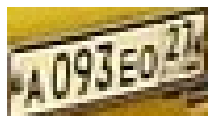

Rotated img:


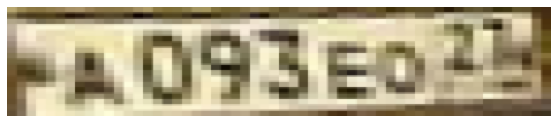

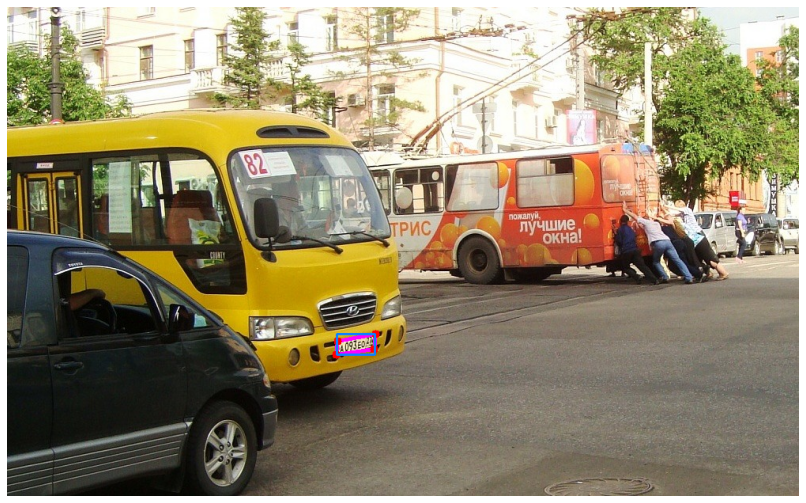

{'boxes': tensor([[417.2760, 414.1473, 465.8395, 440.6247],
         [401.9074, 406.3409, 474.9727, 445.7777]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 'scores': tensor([0.9974, 0.0574], device='cuda:0')}

In [14]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

In [15]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:      
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

 25%|██▍       | 783/3157 [04:53<13:42,  2.88it/s]

simplify_contour didnt coverege


 39%|███▉      | 1231/3157 [07:41<10:40,  3.01it/s]

simplify_contour didnt coverege


 42%|████▏     | 1316/3157 [08:12<13:35,  2.26it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2102/3157 [13:10<06:13,  2.83it/s]

simplify_contour didnt coverege


 72%|███████▏  | 2279/3157 [14:17<05:39,  2.59it/s]

simplify_contour didnt coverege


In [16]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

In [17]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [18]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [21]:
crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/2680 [00:07<14:58,  2.96it/s]

Loss: 5.4870142


  1%|▏         | 40/2680 [00:14<16:36,  2.65it/s]

Loss: 3.6346298


  2%|▏         | 60/2680 [00:21<15:18,  2.85it/s]

Loss: 3.4257754


  3%|▎         | 80/2680 [00:28<16:33,  2.62it/s]

Loss: 3.3164279


  4%|▎         | 100/2680 [00:35<13:55,  3.09it/s]

Loss: 3.2648906


  4%|▍         | 120/2680 [00:42<15:41,  2.72it/s]

Loss: 3.2225624


  5%|▌         | 140/2680 [00:48<14:14,  2.97it/s]

Loss: 3.1438146


  6%|▌         | 160/2680 [00:56<16:29,  2.55it/s]

Loss: 3.1072923


  7%|▋         | 180/2680 [01:03<15:07,  2.75it/s]

Loss: 3.0562220


  7%|▋         | 200/2680 [01:10<14:14,  2.90it/s]

Loss: 3.0340682


  8%|▊         | 220/2680 [01:17<13:48,  2.97it/s]

Loss: 2.9843416


  9%|▉         | 240/2680 [01:24<14:53,  2.73it/s]

Loss: 2.9664494


 10%|▉         | 260/2680 [01:31<14:47,  2.73it/s]

Loss: 2.9134330


 10%|█         | 280/2680 [01:38<12:57,  3.09it/s]

Loss: 2.8747468


 11%|█         | 300/2680 [01:44<12:11,  3.25it/s]

Loss: 2.8358426


 12%|█▏        | 320/2680 [01:51<12:44,  3.09it/s]

Loss: 2.8183475


 13%|█▎        | 340/2680 [01:58<14:05,  2.77it/s]

Loss: 2.7505486


 13%|█▎        | 360/2680 [02:05<13:35,  2.85it/s]

Loss: 2.7264345


 14%|█▍        | 380/2680 [02:13<15:22,  2.49it/s]

Loss: 2.6763396


 15%|█▍        | 400/2680 [02:19<12:49,  2.96it/s]

Loss: 2.6034695


 16%|█▌        | 420/2680 [02:26<15:01,  2.51it/s]

Loss: 2.5409648


 16%|█▋        | 440/2680 [02:33<12:30,  2.98it/s]

Loss: 2.4814405


 17%|█▋        | 460/2680 [02:40<11:17,  3.28it/s]

Loss: 2.4048105


 18%|█▊        | 480/2680 [02:47<12:26,  2.95it/s]

Loss: 2.4078627


 19%|█▊        | 500/2680 [02:54<12:40,  2.87it/s]

Loss: 2.3014535


 19%|█▉        | 520/2680 [03:01<11:40,  3.08it/s]

Loss: 2.2272293


 20%|██        | 540/2680 [03:08<12:15,  2.91it/s]

Loss: 2.2029759


 21%|██        | 560/2680 [03:15<12:04,  2.93it/s]

Loss: 2.1086129


 22%|██▏       | 580/2680 [03:22<11:47,  2.97it/s]

Loss: 2.0431365


 22%|██▏       | 600/2680 [03:29<12:01,  2.88it/s]

Loss: 1.9637614


 23%|██▎       | 620/2680 [03:35<09:58,  3.44it/s]

Loss: 1.8898521


 24%|██▍       | 640/2680 [03:42<11:19,  3.00it/s]

Loss: 1.8070576


 25%|██▍       | 660/2680 [03:49<12:11,  2.76it/s]

Loss: 1.7219546


 25%|██▌       | 680/2680 [03:56<10:26,  3.19it/s]

Loss: 1.6936973


 26%|██▌       | 700/2680 [04:03<12:01,  2.75it/s]

Loss: 1.6219684


 27%|██▋       | 720/2680 [04:10<12:11,  2.68it/s]

Loss: 1.5917898


 28%|██▊       | 740/2680 [04:17<11:33,  2.80it/s]

Loss: 1.4974691


 28%|██▊       | 760/2680 [04:23<11:08,  2.87it/s]

Loss: 1.3970868


 29%|██▉       | 780/2680 [04:30<10:32,  3.00it/s]

Loss: 1.3797204


 30%|██▉       | 800/2680 [04:37<10:59,  2.85it/s]

Loss: 1.3394078


 31%|███       | 820/2680 [04:44<10:58,  2.83it/s]

Loss: 1.1964344


 31%|███▏      | 840/2680 [04:50<10:02,  3.06it/s]

Loss: 1.1199774


 32%|███▏      | 860/2680 [04:57<09:31,  3.18it/s]

Loss: 1.0577106


 33%|███▎      | 880/2680 [05:04<10:27,  2.87it/s]

Loss: 0.9929996


 34%|███▎      | 900/2680 [05:11<11:43,  2.53it/s]

Loss: 1.0284751


 34%|███▍      | 920/2680 [05:18<11:08,  2.63it/s]

Loss: 0.9687161


 35%|███▌      | 940/2680 [05:24<09:38,  3.01it/s]

Loss: 0.8965344


 36%|███▌      | 960/2680 [05:31<09:06,  3.15it/s]

Loss: 0.7821800


 37%|███▋      | 980/2680 [05:38<08:45,  3.23it/s]

Loss: 0.8197724


 37%|███▋      | 1000/2680 [05:45<08:51,  3.16it/s]

Loss: 0.7693482


 38%|███▊      | 1020/2680 [05:51<08:54,  3.10it/s]

Loss: 0.6735391


 39%|███▉      | 1040/2680 [05:58<08:40,  3.15it/s]

Loss: 0.6502077


 40%|███▉      | 1060/2680 [06:04<09:23,  2.87it/s]

Loss: 0.6290638


 40%|████      | 1080/2680 [06:12<08:52,  3.00it/s]

Loss: 0.6360959


 41%|████      | 1100/2680 [06:18<08:21,  3.15it/s]

Loss: 0.5390763


 42%|████▏     | 1120/2680 [06:25<10:08,  2.56it/s]

Loss: 0.5762797


 43%|████▎     | 1140/2680 [06:32<08:55,  2.88it/s]

Loss: 0.5591972


 43%|████▎     | 1160/2680 [06:39<09:13,  2.75it/s]

Loss: 0.5398059


 44%|████▍     | 1180/2680 [06:46<09:39,  2.59it/s]

Loss: 0.5247524


 45%|████▍     | 1200/2680 [06:53<07:43,  3.19it/s]

Loss: 0.5236017


 46%|████▌     | 1220/2680 [06:59<07:04,  3.44it/s]

Loss: 0.4595487


 46%|████▋     | 1240/2680 [07:06<08:33,  2.81it/s]

Loss: 0.4526677


 47%|████▋     | 1260/2680 [07:13<07:39,  3.09it/s]

Loss: 0.5065751


 48%|████▊     | 1280/2680 [07:19<06:40,  3.49it/s]

Loss: 0.4327001


 49%|████▊     | 1300/2680 [07:26<08:28,  2.72it/s]

Loss: 0.4016090


 49%|████▉     | 1320/2680 [07:33<07:25,  3.05it/s]

Loss: 0.4089475


 50%|█████     | 1340/2680 [07:40<07:12,  3.10it/s]

Loss: 0.3998685


 51%|█████     | 1360/2680 [07:46<06:19,  3.48it/s]

Loss: 0.4319341


 51%|█████▏    | 1380/2680 [07:52<07:15,  2.99it/s]

Loss: 0.3777103


 52%|█████▏    | 1400/2680 [07:59<07:24,  2.88it/s]

Loss: 0.3683620


 53%|█████▎    | 1420/2680 [08:06<06:28,  3.25it/s]

Loss: 0.4111819


 54%|█████▎    | 1440/2680 [08:12<06:47,  3.04it/s]

Loss: 0.3759578


 54%|█████▍    | 1460/2680 [08:19<06:54,  2.94it/s]

Loss: 0.3820494


 55%|█████▌    | 1480/2680 [08:25<06:08,  3.25it/s]

Loss: 0.3856876


 56%|█████▌    | 1500/2680 [08:31<06:16,  3.13it/s]

Loss: 0.3954391


 57%|█████▋    | 1520/2680 [08:38<06:28,  2.98it/s]

Loss: 0.3157343


 57%|█████▋    | 1540/2680 [08:44<06:03,  3.13it/s]

Loss: 0.3270422


 58%|█████▊    | 1560/2680 [08:51<06:38,  2.81it/s]

Loss: 0.3458498


 59%|█████▉    | 1580/2680 [08:58<05:44,  3.19it/s]

Loss: 0.3141506


 60%|█████▉    | 1600/2680 [09:05<06:30,  2.76it/s]

Loss: 0.3334804


 60%|██████    | 1620/2680 [09:11<05:00,  3.53it/s]

Loss: 0.3262814


 61%|██████    | 1640/2680 [09:18<05:35,  3.10it/s]

Loss: 0.3510784


 62%|██████▏   | 1660/2680 [09:24<05:20,  3.18it/s]

Loss: 0.3058409


 63%|██████▎   | 1680/2680 [09:31<05:03,  3.30it/s]

Loss: 0.3166906


 63%|██████▎   | 1700/2680 [09:38<05:33,  2.94it/s]

Loss: 0.2906817


 64%|██████▍   | 1720/2680 [09:44<05:07,  3.13it/s]

Loss: 0.2706602


 65%|██████▍   | 1740/2680 [09:50<04:48,  3.26it/s]

Loss: 0.2520233


 66%|██████▌   | 1760/2680 [09:57<04:50,  3.17it/s]

Loss: 0.2757545


 66%|██████▋   | 1780/2680 [10:04<04:58,  3.02it/s]

Loss: 0.2597983


 67%|██████▋   | 1800/2680 [10:10<04:31,  3.25it/s]

Loss: 0.2632425


 68%|██████▊   | 1820/2680 [10:17<04:35,  3.12it/s]

Loss: 0.2806628


 69%|██████▊   | 1840/2680 [10:23<04:16,  3.28it/s]

Loss: 0.2259508


 69%|██████▉   | 1860/2680 [10:30<04:47,  2.85it/s]

Loss: 0.2655335


 70%|███████   | 1880/2680 [10:36<04:02,  3.30it/s]

Loss: 0.2413375


 71%|███████   | 1900/2680 [10:43<03:44,  3.48it/s]

Loss: 0.2013552


 72%|███████▏  | 1920/2680 [10:49<04:54,  2.58it/s]

Loss: 0.2322071


 72%|███████▏  | 1940/2680 [10:55<03:34,  3.44it/s]

Loss: 0.2788164


 73%|███████▎  | 1960/2680 [11:02<03:43,  3.21it/s]

Loss: 0.2489603


 74%|███████▍  | 1980/2680 [11:08<03:57,  2.95it/s]

Loss: 0.2489637


 75%|███████▍  | 2000/2680 [11:15<03:40,  3.08it/s]

Loss: 0.2321585


 75%|███████▌  | 2020/2680 [11:21<03:32,  3.11it/s]

Loss: 0.2571051


 76%|███████▌  | 2040/2680 [11:27<03:16,  3.26it/s]

Loss: 0.2677406


 77%|███████▋  | 2060/2680 [11:34<03:01,  3.41it/s]

Loss: 0.1816108


 78%|███████▊  | 2080/2680 [11:40<03:12,  3.12it/s]

Loss: 0.2512208


 78%|███████▊  | 2100/2680 [11:46<03:03,  3.16it/s]

Loss: 0.2752547


 79%|███████▉  | 2120/2680 [11:53<02:51,  3.27it/s]

Loss: 0.2712109


 80%|███████▉  | 2140/2680 [11:59<03:07,  2.88it/s]

Loss: 0.2408541


 81%|████████  | 2160/2680 [12:05<02:24,  3.60it/s]

Loss: 0.2046670


 81%|████████▏ | 2180/2680 [12:11<02:35,  3.21it/s]

Loss: 0.2239108


 82%|████████▏ | 2200/2680 [12:18<02:48,  2.85it/s]

Loss: 0.2442163


 83%|████████▎ | 2220/2680 [12:24<02:12,  3.47it/s]

Loss: 0.2400083


 84%|████████▎ | 2240/2680 [12:30<02:11,  3.34it/s]

Loss: 0.2048113


 84%|████████▍ | 2260/2680 [12:37<02:31,  2.77it/s]

Loss: 0.2124864


 85%|████████▌ | 2280/2680 [12:43<02:18,  2.89it/s]

Loss: 0.2140857
Epoch   114: reducing learning rate of group 0 to 1.5000e-04.


 86%|████████▌ | 2300/2680 [12:50<02:07,  2.98it/s]

Loss: 0.1842452


 87%|████████▋ | 2320/2680 [12:56<02:02,  2.94it/s]

Loss: 0.1866136


 87%|████████▋ | 2340/2680 [13:02<01:45,  3.24it/s]

Loss: 0.1487745


 88%|████████▊ | 2360/2680 [13:08<01:38,  3.24it/s]

Loss: 0.2048348


 89%|████████▉ | 2380/2680 [13:15<01:35,  3.14it/s]

Loss: 0.2077996


 90%|████████▉ | 2400/2680 [13:21<01:20,  3.46it/s]

Loss: 0.1430782


 90%|█████████ | 2420/2680 [13:27<01:24,  3.07it/s]

Loss: 0.2138289


 91%|█████████ | 2440/2680 [13:34<01:15,  3.19it/s]

Loss: 0.1949848


 92%|█████████▏| 2460/2680 [13:40<01:09,  3.15it/s]

Loss: 0.1771271


 93%|█████████▎| 2480/2680 [13:46<01:04,  3.11it/s]

Loss: 0.1961090


 93%|█████████▎| 2500/2680 [13:53<00:57,  3.12it/s]

Loss: 0.1999360


 94%|█████████▍| 2520/2680 [13:59<00:45,  3.49it/s]

Loss: 0.1569601


 95%|█████████▍| 2540/2680 [14:05<00:47,  2.97it/s]

Loss: 0.1963749


 96%|█████████▌| 2560/2680 [14:12<00:38,  3.13it/s]

Loss: 0.2039604


 96%|█████████▋| 2580/2680 [14:18<00:29,  3.39it/s]

Loss: 0.1622496


 97%|█████████▋| 2600/2680 [14:24<00:24,  3.27it/s]

Loss: 0.1870179


 98%|█████████▊| 2620/2680 [14:31<00:20,  2.90it/s]

Loss: 0.2178963
Epoch   131: reducing learning rate of group 0 to 7.5000e-05.


 99%|█████████▊| 2640/2680 [14:37<00:13,  2.95it/s]

Loss: 0.1655200


 99%|█████████▉| 2660/2680 [14:43<00:05,  3.55it/s]

Loss: 0.1629753


  0%|          | 0/2680 [00:00<?, ?it/s]

Loss: 0.1829883
2679 1.0233255337187048


  1%|          | 20/2680 [00:06<15:38,  2.83it/s]

Loss: 0.1462707


  1%|▏         | 40/2680 [00:12<13:53,  3.17it/s]

Loss: 0.1341141


  2%|▏         | 60/2680 [00:19<14:04,  3.10it/s]

Loss: 0.1242696


  3%|▎         | 80/2680 [00:25<14:02,  3.08it/s]

Loss: 0.1306401


  4%|▎         | 100/2680 [00:31<12:32,  3.43it/s]

Loss: 0.1665982


  4%|▍         | 120/2680 [00:38<14:21,  2.97it/s]

Loss: 0.1364542


  5%|▌         | 140/2680 [00:44<12:37,  3.35it/s]

Loss: 0.1337434


  6%|▌         | 160/2680 [00:51<12:49,  3.27it/s]

Loss: 0.1419314


  7%|▋         | 180/2680 [00:57<14:37,  2.85it/s]

Loss: 0.1498712


  7%|▋         | 200/2680 [01:04<12:09,  3.40it/s]

Loss: 0.1510440


  8%|▊         | 220/2680 [01:10<12:04,  3.39it/s]

Loss: 0.1379535


  9%|▉         | 240/2680 [01:16<12:27,  3.26it/s]

Loss: 0.1520542


 10%|▉         | 260/2680 [01:22<11:57,  3.37it/s]

Loss: 0.1728802


 10%|█         | 280/2680 [01:29<14:38,  2.73it/s]

Loss: 0.1171121


 11%|█         | 300/2680 [01:35<11:01,  3.60it/s]

Loss: 0.1678287


 12%|█▏        | 320/2680 [01:42<13:41,  2.87it/s]

Loss: 0.1569911


 13%|█▎        | 340/2680 [01:48<11:27,  3.40it/s]

Loss: 0.1356194


 13%|█▎        | 360/2680 [01:54<10:37,  3.64it/s]

Loss: 0.1590681


 14%|█▍        | 380/2680 [02:00<12:09,  3.15it/s]

Loss: 0.1268391


 15%|█▍        | 400/2680 [02:07<11:41,  3.25it/s]

Loss: 0.1282004


 16%|█▌        | 420/2680 [02:13<12:24,  3.03it/s]

Loss: 0.1426382


 16%|█▋        | 440/2680 [02:19<11:46,  3.17it/s]

Loss: 0.1175664


 17%|█▋        | 460/2680 [02:25<10:39,  3.47it/s]

Loss: 0.1289189


 18%|█▊        | 480/2680 [02:32<12:37,  2.90it/s]

Loss: 0.1656796


 19%|█▊        | 500/2680 [02:38<10:43,  3.39it/s]

Loss: 0.1059063


 19%|█▉        | 520/2680 [02:44<10:09,  3.54it/s]

Loss: 0.1478908


 20%|██        | 540/2680 [02:50<10:31,  3.39it/s]

Loss: 0.1922566


 21%|██        | 560/2680 [02:57<10:00,  3.53it/s]

Loss: 0.1291810


 22%|██▏       | 580/2680 [03:03<10:27,  3.34it/s]

Loss: 0.1519370


 22%|██▏       | 600/2680 [03:09<13:24,  2.59it/s]

Loss: 0.1479336


 23%|██▎       | 620/2680 [03:15<09:45,  3.52it/s]

Loss: 0.1693261


 24%|██▍       | 640/2680 [03:21<09:32,  3.56it/s]

Loss: 0.1395266


 25%|██▍       | 660/2680 [03:27<10:49,  3.11it/s]

Loss: 0.1219968


 25%|██▌       | 680/2680 [03:34<11:32,  2.89it/s]

Loss: 0.1615602


 26%|██▌       | 700/2680 [03:40<10:33,  3.13it/s]

Loss: 0.1602248


 27%|██▋       | 720/2680 [03:46<09:00,  3.63it/s]

Loss: 0.1514367
Epoch   170: reducing learning rate of group 0 to 3.7500e-05.


 28%|██▊       | 740/2680 [03:53<10:50,  2.98it/s]

Loss: 0.1572458


 28%|██▊       | 760/2680 [03:59<11:01,  2.90it/s]

Loss: 0.1459623


 29%|██▉       | 780/2680 [04:05<10:04,  3.14it/s]

Loss: 0.1565857


 30%|██▉       | 800/2680 [04:11<09:12,  3.41it/s]

Loss: 0.1264065


 31%|███       | 820/2680 [04:17<08:25,  3.68it/s]

Loss: 0.1365283


 31%|███▏      | 840/2680 [04:23<09:32,  3.21it/s]

Loss: 0.1555365


 32%|███▏      | 860/2680 [04:30<09:20,  3.25it/s]

Loss: 0.1229793


 33%|███▎      | 880/2680 [04:36<09:17,  3.23it/s]

Loss: 0.1193176


 34%|███▎      | 900/2680 [04:42<09:53,  3.00it/s]

Loss: 0.1780217


 34%|███▍      | 920/2680 [04:49<09:21,  3.13it/s]

Loss: 0.1541818


 35%|███▌      | 940/2680 [04:56<08:40,  3.34it/s]

Loss: 0.1411083
Epoch   181: reducing learning rate of group 0 to 1.8750e-05.


 36%|███▌      | 960/2680 [05:02<09:58,  2.88it/s]

Loss: 0.1707014


 37%|███▋      | 980/2680 [05:08<07:51,  3.61it/s]

Loss: 0.1263112


 37%|███▋      | 1000/2680 [05:14<08:44,  3.20it/s]

Loss: 0.1264772


 38%|███▊      | 1020/2680 [05:20<08:33,  3.23it/s]

Loss: 0.1288798


 39%|███▉      | 1040/2680 [05:27<09:02,  3.02it/s]

Loss: 0.1597875


 40%|███▉      | 1060/2680 [05:33<07:36,  3.55it/s]

Loss: 0.1865133


 40%|████      | 1080/2680 [05:39<08:26,  3.16it/s]

Loss: 0.1513442


 41%|████      | 1100/2680 [05:45<07:47,  3.38it/s]

Loss: 0.1327180


 42%|████▏     | 1120/2680 [05:51<08:25,  3.09it/s]

Loss: 0.1499987


 43%|████▎     | 1140/2680 [05:58<09:19,  2.75it/s]

Loss: 0.1645974


 43%|████▎     | 1160/2680 [06:04<08:01,  3.15it/s]

Loss: 0.1149496
Epoch   192: reducing learning rate of group 0 to 9.3750e-06.


 44%|████▍     | 1180/2680 [06:11<07:11,  3.47it/s]

Loss: 0.1251758


 45%|████▍     | 1200/2680 [06:17<07:51,  3.14it/s]

Loss: 0.1904689


 46%|████▌     | 1220/2680 [06:24<07:53,  3.08it/s]

Loss: 0.1405053


 46%|████▋     | 1240/2680 [06:30<07:31,  3.19it/s]

Loss: 0.1390817


 47%|████▋     | 1260/2680 [06:37<07:50,  3.02it/s]

Loss: 0.1251335


 48%|████▊     | 1280/2680 [06:43<07:38,  3.05it/s]

Loss: 0.1831526


 49%|████▊     | 1300/2680 [06:49<07:09,  3.21it/s]

Loss: 0.1744064


 49%|████▉     | 1320/2680 [06:56<07:12,  3.14it/s]

Loss: 0.1618593


 50%|█████     | 1340/2680 [07:03<06:48,  3.28it/s]

Loss: 0.1621114


 51%|█████     | 1360/2680 [07:09<06:55,  3.17it/s]

Loss: 0.1589476


 51%|█████▏    | 1380/2680 [07:15<07:13,  3.00it/s]

Loss: 0.1433821
Epoch   203: reducing learning rate of group 0 to 4.6875e-06.


 52%|█████▏    | 1400/2680 [07:21<06:27,  3.31it/s]

Loss: 0.1278331


 53%|█████▎    | 1420/2680 [07:28<06:59,  3.01it/s]

Loss: 0.1544834


 54%|█████▎    | 1440/2680 [07:34<06:14,  3.31it/s]

Loss: 0.1490938


 54%|█████▍    | 1460/2680 [07:40<06:16,  3.24it/s]

Loss: 0.1281870


 55%|█████▌    | 1480/2680 [07:46<06:15,  3.19it/s]

Loss: 0.1474697


 56%|█████▌    | 1500/2680 [07:53<06:03,  3.25it/s]

Loss: 0.1553330


 57%|█████▋    | 1520/2680 [08:00<06:38,  2.91it/s]

Loss: 0.1265154


 57%|█████▋    | 1540/2680 [08:06<05:34,  3.41it/s]

Loss: 0.1114902


 58%|█████▊    | 1560/2680 [08:12<05:47,  3.22it/s]

Loss: 0.1384335


 59%|█████▉    | 1580/2680 [08:18<06:11,  2.96it/s]

Loss: 0.1395968


 60%|█████▉    | 1600/2680 [08:25<06:39,  2.71it/s]

Loss: 0.1198984
Epoch   214: reducing learning rate of group 0 to 2.3437e-06.


 60%|██████    | 1620/2680 [08:31<05:51,  3.01it/s]

Loss: 0.1656512


 61%|██████    | 1640/2680 [08:37<05:01,  3.45it/s]

Loss: 0.1187777


 62%|██████▏   | 1660/2680 [08:44<05:38,  3.01it/s]

Loss: 0.1405893


 63%|██████▎   | 1680/2680 [08:50<05:22,  3.10it/s]

Loss: 0.1369159


 63%|██████▎   | 1700/2680 [08:57<05:06,  3.20it/s]

Loss: 0.1072754


 64%|██████▍   | 1720/2680 [09:03<05:18,  3.01it/s]

Loss: 0.1430137


 65%|██████▍   | 1740/2680 [09:09<05:48,  2.70it/s]

Loss: 0.1707441


 66%|██████▌   | 1760/2680 [09:16<04:42,  3.26it/s]

Loss: 0.1538690


 66%|██████▋   | 1780/2680 [09:22<05:06,  2.94it/s]

Loss: 0.1371353


 67%|██████▋   | 1800/2680 [09:29<05:00,  2.93it/s]

Loss: 0.1636984


 68%|██████▊   | 1820/2680 [09:35<04:36,  3.12it/s]

Loss: 0.1257191
Epoch   225: reducing learning rate of group 0 to 1.1719e-06.


 69%|██████▊   | 1840/2680 [09:41<04:49,  2.90it/s]

Loss: 0.1505402


 69%|██████▉   | 1860/2680 [09:48<04:40,  2.93it/s]

Loss: 0.1553417


 70%|███████   | 1880/2680 [09:54<04:25,  3.02it/s]

Loss: 0.1511500


 71%|███████   | 1900/2680 [10:01<04:02,  3.22it/s]

Loss: 0.1434512


 72%|███████▏  | 1920/2680 [10:07<03:53,  3.25it/s]

Loss: 0.1361691


 72%|███████▏  | 1940/2680 [10:13<04:02,  3.05it/s]

Loss: 0.1536154


 73%|███████▎  | 1960/2680 [10:19<03:50,  3.13it/s]

Loss: 0.1263776


 74%|███████▍  | 1980/2680 [10:26<03:39,  3.19it/s]

Loss: 0.1130656


 75%|███████▍  | 2000/2680 [10:32<03:21,  3.37it/s]

Loss: 0.1537530


 75%|███████▌  | 2020/2680 [10:39<03:26,  3.19it/s]

Loss: 0.1181370


 76%|███████▌  | 2040/2680 [10:45<03:17,  3.23it/s]

Loss: 0.1223640
Epoch   236: reducing learning rate of group 0 to 5.8594e-07.


 77%|███████▋  | 2060/2680 [10:51<03:18,  3.13it/s]

Loss: 0.1493192


 78%|███████▊  | 2080/2680 [10:58<02:53,  3.46it/s]

Loss: 0.1356625


 78%|███████▊  | 2100/2680 [11:04<03:06,  3.11it/s]

Loss: 0.1326664


 79%|███████▉  | 2120/2680 [11:11<03:10,  2.95it/s]

Loss: 0.1468031


 80%|███████▉  | 2140/2680 [11:17<02:52,  3.13it/s]

Loss: 0.1371000


 81%|████████  | 2160/2680 [11:23<02:57,  2.93it/s]

Loss: 0.1518023


 81%|████████▏ | 2180/2680 [11:30<02:49,  2.96it/s]

Loss: 0.1653406


 82%|████████▏ | 2200/2680 [11:36<02:42,  2.95it/s]

Loss: 0.1453675


 83%|████████▎ | 2220/2680 [11:43<02:22,  3.24it/s]

Loss: 0.1664299


 84%|████████▎ | 2240/2680 [11:49<02:24,  3.06it/s]

Loss: 0.1585176


 84%|████████▍ | 2260/2680 [11:55<02:18,  3.04it/s]

Loss: 0.1226136
Epoch   247: reducing learning rate of group 0 to 2.9297e-07.


 85%|████████▌ | 2280/2680 [12:01<01:58,  3.39it/s]

Loss: 0.1351367


 86%|████████▌ | 2300/2680 [12:07<01:48,  3.49it/s]

Loss: 0.1508920


 87%|████████▋ | 2320/2680 [12:13<01:49,  3.29it/s]

Loss: 0.1456895


 87%|████████▋ | 2340/2680 [12:20<01:52,  3.02it/s]

Loss: 0.0936178


 88%|████████▊ | 2360/2680 [12:26<01:38,  3.23it/s]

Loss: 0.1294025


 89%|████████▉ | 2380/2680 [12:32<01:30,  3.30it/s]

Loss: 0.1309510


 90%|████████▉ | 2400/2680 [12:39<01:24,  3.31it/s]

Loss: 0.1452821


 90%|█████████ | 2420/2680 [12:45<01:18,  3.30it/s]

Loss: 0.1217233


 91%|█████████ | 2440/2680 [12:51<01:18,  3.04it/s]

Loss: 0.1444238


 92%|█████████▏| 2460/2680 [12:58<01:11,  3.08it/s]

Loss: 0.1495973


 93%|█████████▎| 2480/2680 [13:04<01:02,  3.20it/s]

Loss: 0.1294502


 93%|█████████▎| 2500/2680 [13:11<00:56,  3.18it/s]

Loss: 0.1402957


 94%|█████████▍| 2520/2680 [13:17<00:50,  3.17it/s]

Loss: 0.1617902


 95%|█████████▍| 2540/2680 [13:24<00:52,  2.66it/s]

Loss: 0.1486490


 96%|█████████▌| 2560/2680 [13:31<00:41,  2.89it/s]

Loss: 0.1498898
Epoch   262: reducing learning rate of group 0 to 1.4648e-07.


 96%|█████████▋| 2580/2680 [13:37<00:32,  3.08it/s]

Loss: 0.1762284


 97%|█████████▋| 2600/2680 [13:44<00:23,  3.37it/s]

Loss: 0.1489952


 98%|█████████▊| 2620/2680 [13:50<00:20,  2.90it/s]

Loss: 0.1757261


 99%|█████████▊| 2640/2680 [13:57<00:12,  3.11it/s]

Loss: 0.1825783


 99%|█████████▉| 2660/2680 [14:03<00:07,  2.78it/s]

Loss: 0.1477332


Loss: 0.1454755
2679 0.14451252709962983


In [22]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission.csv', index=False)

In [ ]:
import pandas as pd
sample = pd.read_csv("data/sampleSubmission.csv")
res = pd.read_csv("submission.csv")

In [ ]:
sample

,file_name,plates_string
0,test/0.jpg,X000XX00
1,test/1.jpg,X000XX00
2,test/2.jpg,X000XX00
3,test/3.jpg,X000XX00
4,test/4.bmp,X000XX00
...,...,...
3152,test/3182.jpg,X000XX00
3153,test/3183.jpg,X000XX00
3154,test/3184.jpg,X000XX00
3155,test/3185.bmp,X000XX00


In [ ]:
res

,file_name,plates_string
0,test/1519.bmp,B926XE35
1,test/2677.bmp,H872KH197
2,test/2181.png,O225OK98 T338YA178
3,test/921.jpg,P327MM76
4,test/2710.bmp,B818EY35
...,...,...
3152,test/764.jpg,K111BP199
3153,test/2123.jpg,K209XH46
3154,test/1321.bmp,T645XE35
3155,test/2632.jpg,X079HK74 X601KP174
